# `Soundscapy` - Quick Start Guide

By Andrew Mitchell, Lecturer, University College London

## Background

`Soundscapy` is a python toolbox for analysing quantitative soundscape data. Urban soundscapes are typically assessed through surveys which ask respondents how they perceive the given soundscape. Particularly when collected following the technical specification ISO 12913, these surveys can constitute quantitative data about the soundscape perception. As proposed in *How to analyse and represent quantitative soundscape data* [(Mitchell, Aletta, & Kang, 2022)](https://asa.scitation.org/doi/full/10.1121/10.0009794), in order to describe the soundscape perception of a group or of a location, we should consider the distribution of responses. `Soundscapy`'s approach to soundscape analysis follows this approach and makes it simple to process soundscape data and visualise the distribution of responses. 

For more information on the theory underlying the assessments and forms of data collection, please see ISO 12913-Part 2, *The SSID Protocol* [(Mitchell, *et al.*, 2020)](https://www.mdpi.com/2076-3417/10/7/2397), and *How to analyse and represent quantitative soundscape data*.

## This Notebook

The purpose of this notebook is to give a brief overview of how `Soundscapy` works and how to quickly get started using it to analyse your own soundscape data. The example dataset used is *The International Soundscape Database (ISD)* (Mitchell, *et al.*, 2021), which is publicly available at [Zenodo](https://zenodo.org/record/6331810) and is free to use. `Soundscapy` expects data to follow the format used in the ISD, but can be adapted for similar datasets.

----------

## Installation

To install Soundscapy with `pip`:

```
pip install soundscapy
```

----

## Working with Data

### Loading and Validating Data

Let's start by importing Soundscapy and loading the International Soundscape Database (ISD):


In [15]:
from soundscapy import setup_logging

setup_logging("WARNING")

In [16]:
# Import Soundscapy
import soundscapy as sspy
from soundscapy.databases import isd

# Load the ISD dataset
data = isd.load()
print(data.shape)

# Validate the dataset with ISD-custom checks
df, excl = isd.validate(data)
print(f"Valid samples: {data.shape[0]}, Excluded samples: {excl.shape[0]}")

(3589, 142)
Valid samples: 3589, Excluded samples: 56


### Calculating ISOPleasant and ISOEventful Coordinates

Next, we'll calculate the ISOCoordinate values:

In [17]:
data = sspy.surveys.add_iso_coords(data)
data[["ISOPleasant", "ISOEventful"]].head()

,ISOPleasant,ISOEventful
0,0.219670,-0.133883
1,-0.426777,0.530330
2,0.676777,-0.073223
3,0.603553,-0.146447
4,0.457107,-0.146447


`Soundscapy` expects the PAQ values to be Likert scale values ranging from 1 to 5 by default, as specified in ISO 12913 and the SSID Protocol. However, it is possible to use data which, although structured the same way, has a different range of values. For instance this could be a 7-point Likert scale, or a 0 to 100 scale. By passing these numbers both to `validate_dataset()` and `add_paq_coords()` as the `val_range`, `Soundscapy` will check that the data conforms to what is expected and will automatically scale the ISOCoordinates from -1 to +1 depending on the original value range. 

For example:

In [18]:
import pandas as pd

val_range = (0, 100)
sample_transform = {
    "RecordID": ["EX1", "EX2"],
    "pleasant": [40, 25],
    "vibrant": [45, 31],
    "eventful": [41, 54],
    "chaotic": [24, 56],
    "annoying": [8, 52],
    "monotonous": [31, 55],
    "uneventful": [37, 31],
    "calm": [40, 10],
}
sample_transform = pd.DataFrame().from_dict(sample_transform)
sample_transform = sspy.surveys.rename_paqs(sample_transform)
sample_transform = sspy.surveys.add_iso_coords(sample_transform, val_range=val_range)
sample_transform

,RecordID,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8,ISOPleasant,ISOEventful
0,EX1,40,45,41,24,8,31,37,40,0.220416,0.010711
1,EX2,25,31,54,56,52,55,31,10,-0.316863,0.159706


### Filtering Data

`Soundscapy` includes methods for several filters that are normally needed within the ISD, such as filtering by `LocationID` or `SessionID`.

In [19]:
# Filter by location
camden_data = isd.select_location_ids(data, ["CamdenTown"])
print(f"Camden Town samples: {camden_data.shape[0]}")

# Filter by session
regent_data = isd.select_session_ids(data, ["RegentsParkJapan1"])
print(f"Regent's Park Japan session 1 samples: {regent_data.shape[0]}")

# Complex filtering using pandas query
women_over_50 = df.query("gen00 == 'Female' and age00 > 50")
print(f"Women over 50: {women_over_50.shape[0]}")

Camden Town samples: 105
Regent's Park Japan session 1 samples: 46
Women over 50: 133


All of these filters can also be chained together. So, for instance, to return surveys from women over 50 taken in Camden Town, we would do:

In [20]:
isd.select_location_ids(data, "CamdenTown").query("gen00 == 'Female' and age00 > 50")

,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max,ISOPleasant,ISOEventful
58,CamdenTown,CamdenTown1,CT108,531,2019-05-02 12:10:52,2019-05-02 12:26:45,51.539124,-0.142624,eng,engISO2018,...,-2.12,-4.44,72.28,45.05,37.19,13.40,-1.88,-2.45,-1.464466e-01,0.146447
63,CamdenTown,CamdenTown1,CT111,533,2019-05-02 12:29:42,2019-05-02 12:58:56,51.539124,-0.142624,eng,engISO2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.142136e-01,-0.457107
104,CamdenTown,CamdenTown3,CT311,593,2019-05-20 12:24:14,2019-05-20 12:28:27,51.539124,-0.142624,eng,engISO2018,...,-4.73,-8.48,76.20,44.21,34.12,11.04,-4.83,-5.99,-1.464466e-01,0.146447
105,CamdenTown,CamdenTown3,CT311,623,2019-05-20 12:25:00,2019-05-20 12:30:00,51.539124,-0.142624,eng,engISO2018,...,-4.73,-8.48,76.20,44.21,34.12,11.04,-4.83,-5.99,1.338835e-01,0.073223
122,CamdenTown,CamdenTown3,CT324,609,2019-05-20 13:51:00,2019-05-20 13:57:00,51.539124,-0.142624,eng,engISO2018,...,-1.53,-9.57,75.83,43.30,33.73,11.88,-5.59,-7.44,1.767767e-01,0.926777
128,CamdenTown,CamdenTown3,CT328,617,2019-05-20 14:13:00,2019-05-20 14:16:00,51.539124,-0.142624,eng,engISO2018,...,-5.89,-1.76,71.56,45.97,38.80,17.59,2.64,1.16,-4.393398e-01,0.250000
132,CamdenTown,CamdenTown4,CT403,1220,2019-07-13 12:31:40,2019-07-13 12:35:30,51.539140,-0.142648,eng,engISO2018,...,-1.32,-3.24,71.78,49.81,42.16,16.53,0.54,-0.65,-4.598694e-17,0.603553


## Plotting

Soundscapy offers various plotting functions to visualize soundscape data. Let's explore some of them:

### Scatter plots


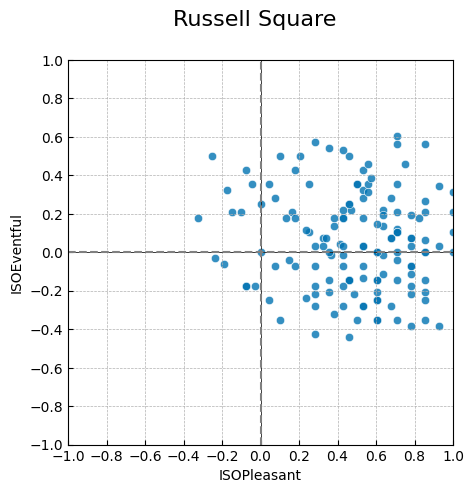

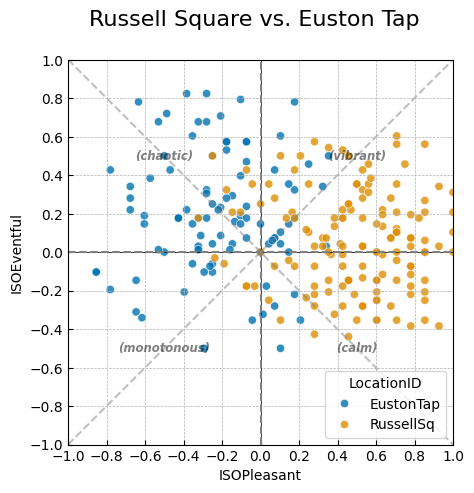

In [21]:
import matplotlib.pyplot as plt

from soundscapy.plotting import CircumplexPlot

# Basic scatter plot
p1 = (
    CircumplexPlot(
        data=isd.select_location_ids(data, ["RussellSq"]), title="Russell Square"
    )
    .create_subplots()
    .add_scatter()
    .apply_styling()
)
plt.show()

# Customized scatter plot with multiple locations
p2 = (
    CircumplexPlot(
        data=isd.select_location_ids(data, ["RussellSq", "EustonTap"]),
        title="Russell Square vs. Euston Tap",
        hue="LocationID",
    )
    .create_subplots()
    .add_scatter()
    .apply_styling(diagonal_lines=True, legend_location="lower right")
)
plt.show()

The CircumplexPlot also allows us to make this set of plots in one go, as a single figure. To do this, we need to set up the subplots slightly differently, then pass the subplot data to each .add_scatter() call separately, rather than passing the whold dataframe to the CircumplexPlot object.

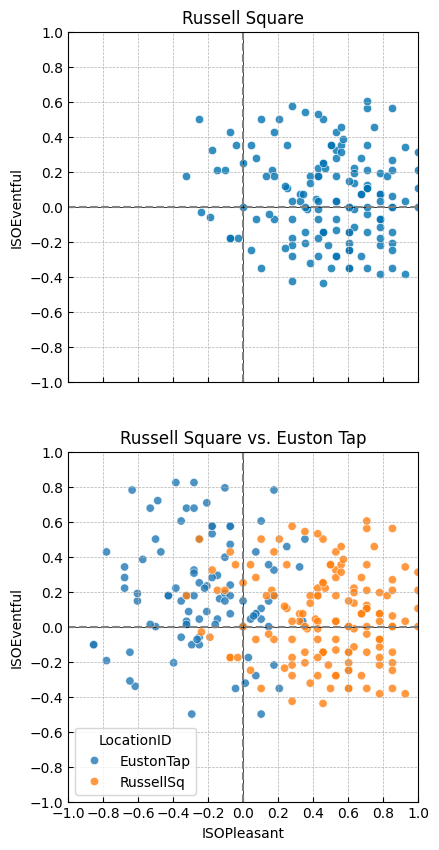

In [22]:
p3 = (
    CircumplexPlot(title=None)
    .create_subplots(
        2, 1, subplot_titles=["Russell Square", "Russell Square vs. Euston Tap"]
    )
    .add_scatter(data=isd.select_location_ids(data, ["RussellSq"]), on_axis=0)
    .add_scatter(
        data=isd.select_location_ids(data, ["RussellSq", "EustonTap"]),
        on_axis=1,
        hue="LocationID",
    )
    .apply_styling()
)
plt.show()

### Density plots

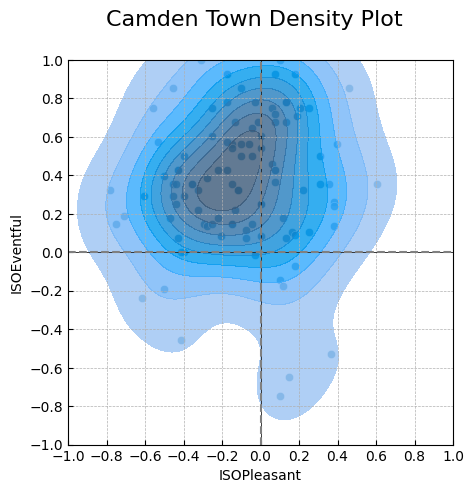

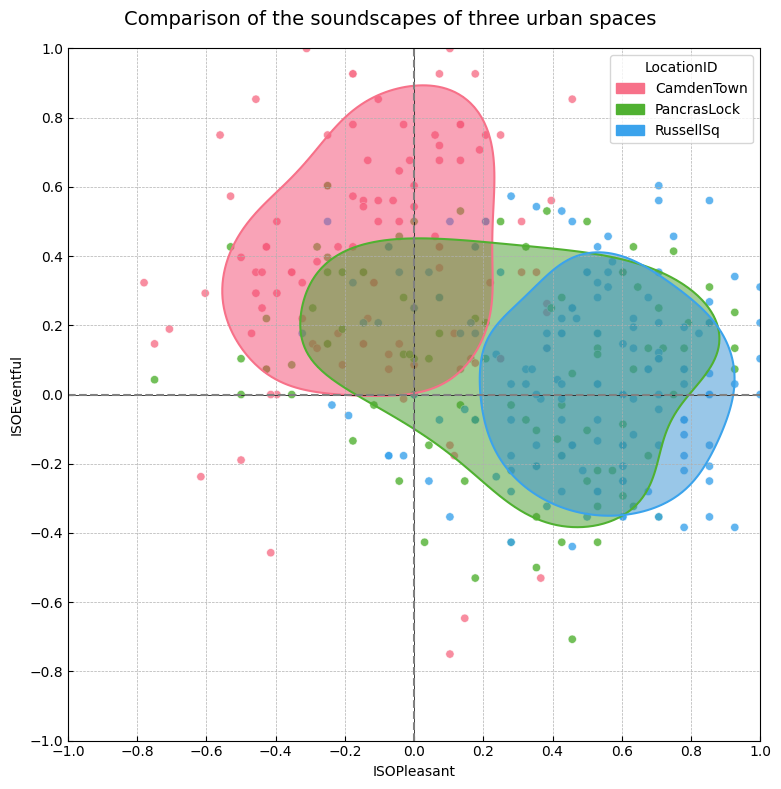

In [23]:
d1 = (
    CircumplexPlot(
        data=isd.select_location_ids(data, ["CamdenTown"]),
        title="Camden Town Density Plot",
    )
    .create_subplots()
    .add_scatter()
    .add_density()
    .apply_styling()
)
plt.show()

d2 = (
    CircumplexPlot(
        data=isd.select_location_ids(data, ["CamdenTown", "RussellSq", "PancrasLock"]),
        title="Comparison of the soundscapes of three urban spaces",
        title_fontsize=14,
        hue="LocationID",
        palette="husl",
    )
    .create_subplots(figsize=(8, 8))
    .add_scatter()
    .add_simple_density(hue="LocationID")
    .apply_styling()
)
plt.tight_layout()
plt.show()

### Jointplots


In [24]:
# from soundscapy.plotting.circumplex_plot import Backend, CircumplexPlot

# plot = CircumplexPlot(
#     isd.select_location_ids(df, ["CamdenTown"]), backend=Backend.SEABORN
# )
# plot.jointplot()
# plot.show()

### Creating subplots

`Soundscapy` also provides a method for creating subplots of the circumplex. This is particularly useful when comparing multiple locations.

In [25]:
df["LocationID"].unique()

array(['CarloV', 'SanMarco', 'PlazaBibRambla', 'CamdenTown', 'EustonTap',
       'Noorderplantsoen', 'MarchmontGarden', 'MonumentoGaribaldi',
       'TateModern', 'PancrasLock', 'TorringtonSq', 'RegentsParkFields',
       'RegentsParkJapan', 'RussellSq', 'StPaulsCross', 'StPaulsRow',
       'CampoPrincipe', 'MiradorSanNicolas', 'LianhuashanParkEntrance',
       'LianhuashanParkForest', 'PingshanPark', 'PingshanStreet',
       'ZhongshanPark', 'OlympicSquare', 'ZhongshanSquare',
       'DadongSquare'], dtype=object)

/Users/mitch/Documents/GitHub/Soundscapy/src/soundscapy/plotting/circumplex_plot.py:253: UserWarning: This is an experimental feature. The number of rows and columns may not be optimal.
  nrows, ncols = self._allocate_subplot_axes(subplot_titles)


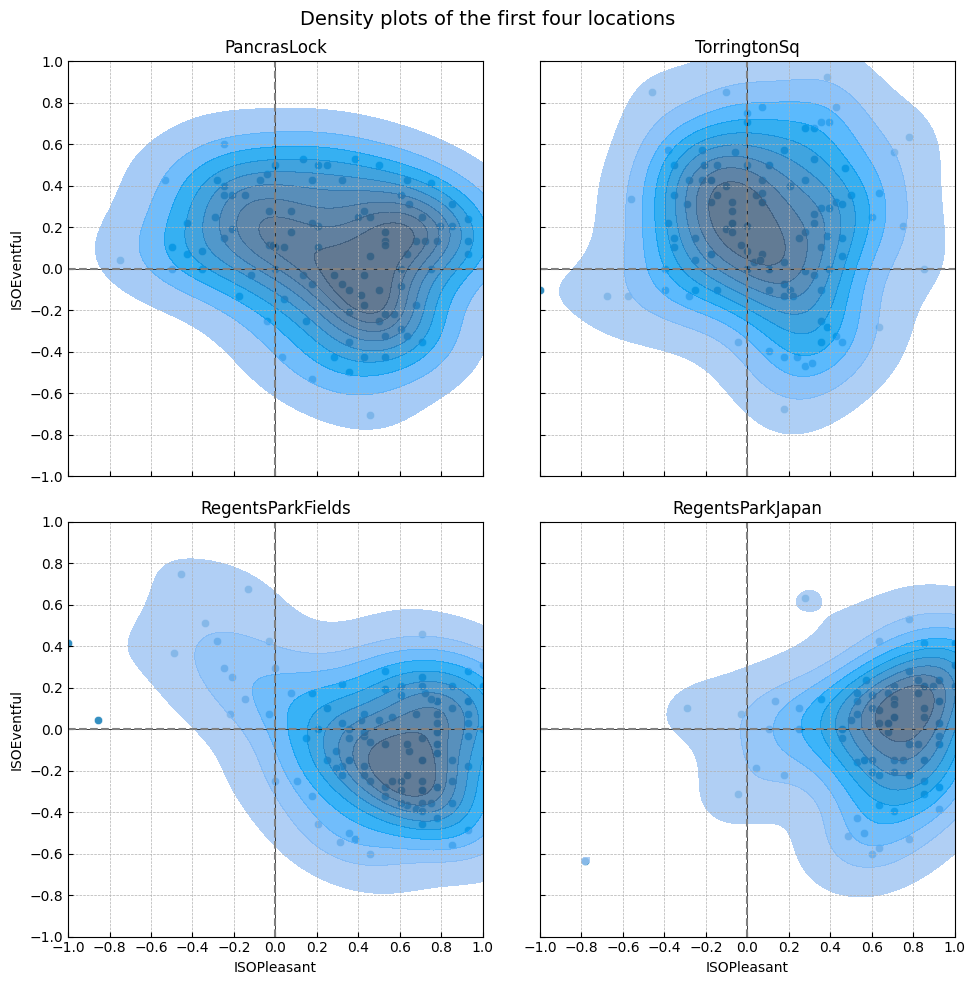

In [26]:
sub_data = sspy.isd.select_location_ids(
    data, ["PancrasLock", "TorringtonSq", "RegentsParkFields", "RegentsParkJapan"]
)

mp1 = (
    CircumplexPlot(
        data=sub_data,
        title="Density plots of the first four locations",
        title_fontsize=14,
    )
    .create_subplots(subplot_by="LocationID", auto_allocate_axes=True)
    .add_scatter()
    .add_density()
    .apply_styling()
)

plt.tight_layout()
plt.show()

You can also do this manually if you need more control, by creating a figure and axes and then plotting the density plots on the axes.

/Users/mitch/Documents/GitHub/Soundscapy/src/soundscapy/plotting/circumplex_plot.py:757: UserWarning: Density plots are not recommended for small datasets (<30 samples).
  self._valid_density(d)


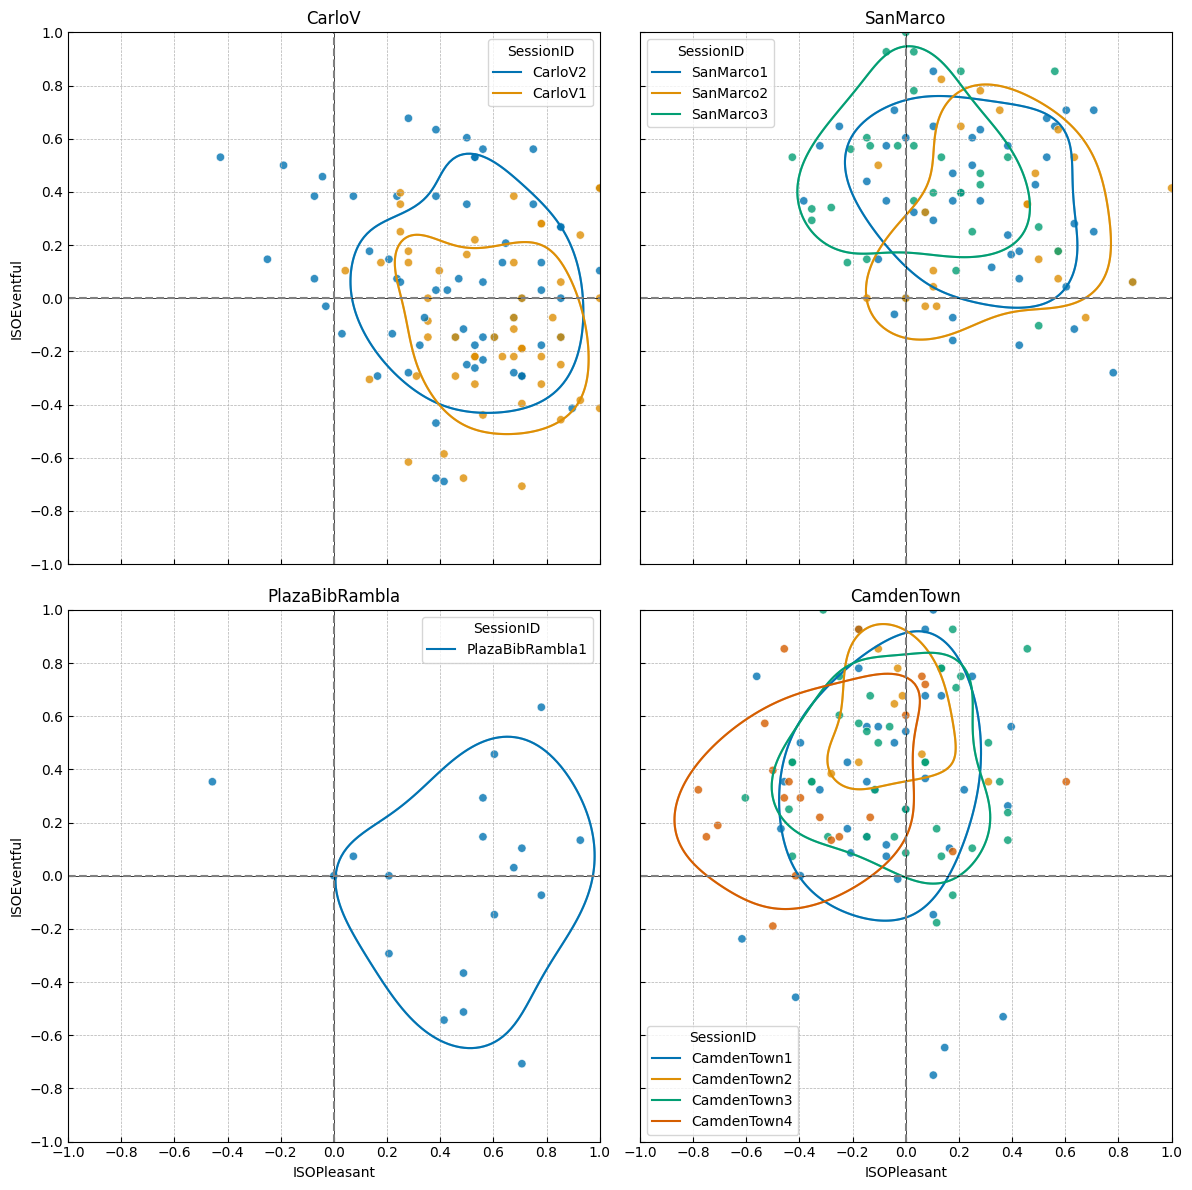

In [27]:
sub_data2 = sspy.isd.select_location_ids(
    data, ["CarloV", "SanMarco", "PlazaBibRambla", "CamdenTown"]
)

mp2 = (
    CircumplexPlot(
        data=sub_data2,
        title=None,
        hue="SessionID",
    )
    .create_subplots(
        2,
        2,
        subplot_by="LocationID",
        figsize=(12, 12),
        adjust_figsize=False,
    )
    .add_scatter()
    .add_simple_density(fill=False)
    .apply_styling()
)

plt.tight_layout()
plt.show()

### Using Adjusted Angles

In Aletta et. al. (2024), we propose a method for adjusting the angles of the circumplex to better represent the perceptual space. These adjusted angles are derived for each language separately, meaning that, once projected, the circumplex coordinates will be comparable across all languages. This ability and the derived angles have been incorporated into `Soundscapy`.

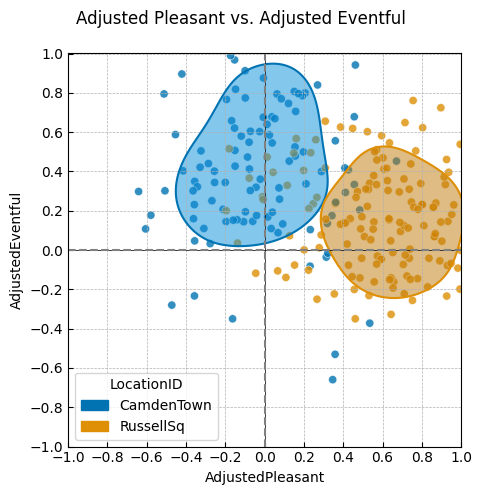

In [28]:
from soundscapy.surveys import LANGUAGE_ANGLES

adj_data = sspy.surveys.add_iso_coords(
    data,
    names=("AdjustedPleasant", "AdjustedEventful"),
    angles=LANGUAGE_ANGLES["eng"],
    overwrite=True,
)

adj_p = (
    CircumplexPlot(
        data=isd.select_location_ids(adj_data, ["CamdenTown", "RussellSq"]),
        xcol="AdjustedPleasant",
        ycol="AdjustedEventful",
        hue="LocationID",
        title="Adjusted Pleasant vs. Adjusted Eventful",
        title_fontsize=12,
    )
    .create_subplots()
    .add_scatter()
    .add_simple_density()
    .apply_styling()
)

plt.tight_layout()
plt.show()